# Total vs. allele-specific accessibility

Are differences in allelic accessibility reflected in total counts?

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import probplot

sc.settings.verbosity = 3

In [5]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [6]:
from scdali.models import DaliHet
from scdali.utils.stats import apply_fdr_bh
from tqdm import trange

In [7]:
# local
sys.path.append('..')
from utils import settings

## Global variables

In [39]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Plot settings

In [40]:
SAVE_PLOTS = True

In [41]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
sns.set_style("ticks")

In [42]:
PLOT_DIRECTORY = 'figures/total_vs_allelic'
if not os.path.exists(PLOT_DIRECTORY):
    os.makedirs(PLOT_DIRECTORY)

## Load anndata

In [30]:
adatas = list()
for exp_id in settings.F1_EXP_IDS:
    adata = sc.read(os.path.join(settings.DATA_DIR, label, '_'.join([exp_id, regions, correction, 'allelic_counts_processed.h5ad'])))
    adatas.append(adata[:, adata.var[DALIHET_PVAL + '_bh'] < 0.1])

In [32]:
pvals_totalcounts = list()
pvals_cellstate = list()

for adata in adatas:
    for i in trange(adata.shape[1]):
        model = DaliHet(
            a=adata[:, i].X.A,
            d=adata[:, i].layers['allelic_total'].A,
            E=adata[:, i].layers['allelic_total'].A)
        model.fit()
        pvals_totalcounts.append(model.test())
    pvals_cellstate += adata.var[DALIHET_PVAL].tolist()

pvals_cellstate = np.asarray(pvals_cellstate)
pvals_totalcounts = np.asarray(pvals_totalcounts)

100%|██████████| 101/101 [00:13<00:00,  7.30it/s]


[3.6 1.8]


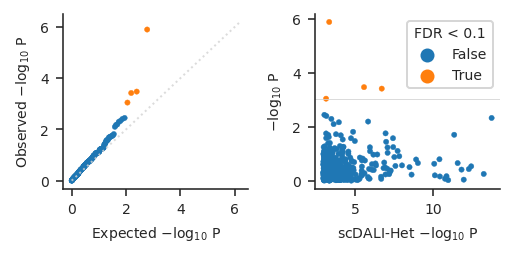

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(3.6, 1.8))

ax = axes[0]
(osm, osr), _ = probplot(pvals_totalcounts, dist='uniform')
pvals_significant = pvals_totalcounts[apply_fdr_bh(pvals_totalcounts) < 0.1]
fdr_cutoff = pvals_significant.max()
sns.scatterplot(
    x=-np.log10(osm), 
    y=-np.log10(osr), 
    hue=osr<=fdr_cutoff, 
    edgecolor=None, 
    rasterized=True,
    s=7,
    legend=False,
    ax=ax)
ax_max = max(ax.get_ylim()[1], ax.get_xlim()[1])
ax.plot([0, ax_max], [0, ax_max], alpha=0.8, linestyle=':', c='lightgrey', linewidth=1)
ax.set(
    xlabel=r'Expected $-\log_{10}$ P',
    ylabel=r'Observed $-\log_{10}$ P')

ax = axes[1]
sns.scatterplot(
    y=-np.log10(pvals_totalcounts), 
    x=-np.log10(pvals_cellstate), 
    edgecolor=None, 
    rasterized=True,
    hue=pvals_totalcounts<=fdr_cutoff,
    s=7,
    ax=ax)
ax.axhline(-np.log10(fdr_cutoff), c='lightgrey', alpha=0.8, linewidth=0.5)
ax.legend(title='FDR < 0.1', markerscale=1)

ax.set(
    ylabel=r'$-\log_{10}$ P', 
    xlabel=r'scDALI-Het $-\log_{10}$ P')
plt.tight_layout()
sns.despine()

print(fig.get_size_inches())
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/total_vs_allelic.svg', dpi=350)

In [37]:
pvals_significant.size

4